# Général

In [6]:
import numpy as np
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
import pandas as pd
from sklearn.metrics import classification_report
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords

In [7]:
data =pd.read_csv("corpus/donnees_classifieur.csv",sep=",,") #oral = 1, écrit = 0

# Exploration des données : forme, nombre d'instances par catégorie

Nombre de lignes et de colonnes : (3201, 2)
Premières lignes du document : 
                                               texte  label
0  Leos Carax,cinéaste (dernier film : Annette) L...      0
1  enflammés frapper douze jeunes antiracistes lo...      0
2  mercie ces jeunes garçons et filles de s'être ...      0
3  x, périlleux, me fait toujours soupçonner : re...      0
4  e)commencé ? Je pense au jeune plombier Isador...      0


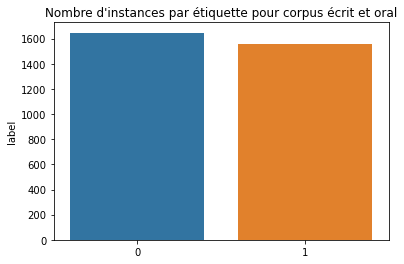

In [8]:
def exploration_donnees(dataset,nom_dataset,label='label'):
    
    
    #préciser le nom de la catégorie qui contient les étiquettes ("label" pour les tweets)
    print("Nombre de lignes et de colonnes :", dataset.shape)
    print("Premières lignes du document : ")
    print(dataset.head())
    x=dataset[label].value_counts()
    titre = "Nombre d'instances par étiquette pour %s"%nom_dataset
    sns.barplot(x.index,x).set(title=titre)
    plt.savefig("%s.png"%titre)

exploration_donnees(data,"corpus écrit et oral")

Moyenne de mots par classe : 
25.78185328185328 pour les oral
25.140862173649058 pour les écrit

Moyenne de caractères par instance: 
142.3056628056628 pour les oral
144.05403764420157 pour les écrit

Moyenne de mots uniques par instance : 
21.27155727155727 pour les oral
23.423800850030357 pour les écrit


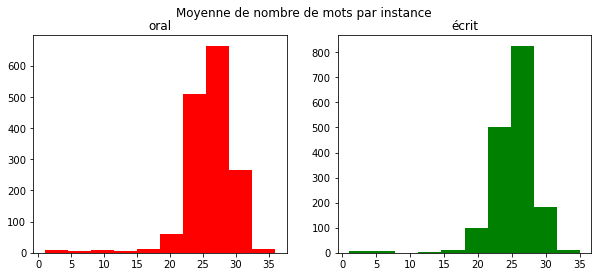

In [10]:
# fonction adaptée du code disponible à l'adresse 
#https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e )

def stats_donnees(dataset, cat_1="oral", cat_0="écrit", label="label"):
    
    ''' Fonction qui fournit des statistiques et des graphiques sur les données '''
    #1. WORD-COUNT
    dataset['word_count'] = dataset["texte"].apply(lambda x: len(str(x).split()))
    print("Moyenne de mots par classe : ")
    print(dataset[dataset[label]==1]['word_count'].mean(), "pour les %s"%cat_1) 
    print(dataset[dataset[label]==0]['word_count'].mean(), "pour les %s"%cat_0) 
    
    #2. CHARACTER-COUNT
    dataset['char_count'] = dataset['texte'].apply(lambda x: len(str(x)))
    print("\nMoyenne de caractères par instance: ")
    print(dataset[dataset[label]==1]['char_count'].mean(), "pour les %s"%cat_1) 
    print(dataset[dataset[label]==0]['char_count'].mean(), "pour les %s"%cat_0)

    #3. UNIQUE WORD-COUNT
    dataset['unique_word_count'] = dataset['texte'].apply(lambda x: len(set(str(x).split())))
    print("\nMoyenne de mots uniques par instance : ")
    print(dataset[dataset[label]==1]['unique_word_count'].mean(), "pour les %s"%cat_1)
    print(dataset[dataset[label]==0]['unique_word_count'].mean(), "pour les %s"%cat_0)
    
    #Plotting word-count per tweet
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
    train_words=dataset[dataset[label]==1]['word_count']
    ax1.hist(train_words,color='red')
    ax1.set_title(cat_1)
    train_words=dataset[dataset[label]==0]['word_count']
    ax2.hist(train_words,color='green')
    ax2.set_title(cat_0)
    fig.suptitle('Moyenne de nombre de mots par instance')
    plt.show()
    
stats_donnees(data)

# Entraînement des classifieurs

On commence par tester plusieurs classifieurs avec le CountVectorizer par défaut pour voir si certains classifieurs se démarquent

In [11]:
#INPUT (constant) : imports et initialisations de variables à réutiliser

# stopw_en = set(stopwords.words('english'))
# stopw_fr = set(stopwords.words('french'))

X1 = data["texte"],
y = data["label"],
stopw = set(stopwords.words('french'))
    
liste_vec = [["CountVectorizer", CountVectorizer()],
             ["TFIDFVectorizer", TfidfVectorizer()]]
#liste de listes de classifieurs (pour étapes suivantes)


liste_classif = [["Perceptron", Perceptron(eta0=0.1, random_state=RANDOM_SEED)], 
                 ["SVM", svm.SVC(random_state=RANDOM_SEED)],
                 ["Nearest Neighbors", KNeighborsClassifier(3)],
                 ["Random Forest", RandomForestClassifier(random_state=RANDOM_SEED)],
                 ["DecisionTree",DecisionTreeClassifier(random_state=RANDOM_SEED)]]

liste_param = [["sans stop_words",CountVectorizer(stop_words=stopw)],
               ["avec 1000 mots",CountVectorizer(max_features=1000)],
               ["avec 2000 mots",CountVectorizer(max_features=2000)],
               ["avec 500 mots",CountVectorizer(max_features=500)],
               ["avec bigrammes",CountVectorizer(ngram_range=(2,2))],
               ["par caractère",CountVectorizer(analyzer='char')]]

def trier_dic(dic):
    L = [[effectif,car] for car,effectif in dic.items()]
    L_sorted = sorted(L, reverse=True)
    return [[car,effectif] for effectif,car in L_sorted]

Perceptron


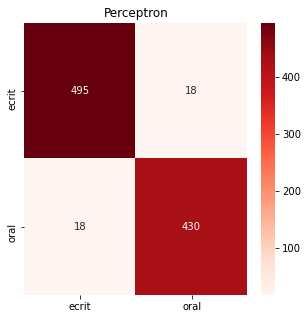

**************
SVM


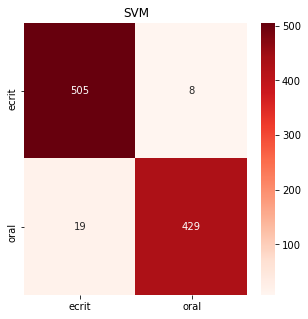

**************
Nearest Neighbors


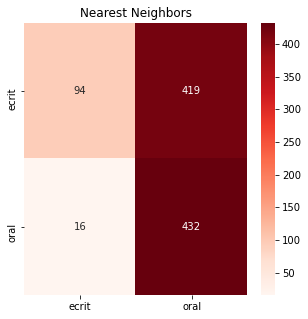

**************
Random Forest


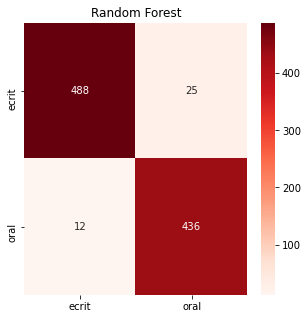

**************
DecisionTree


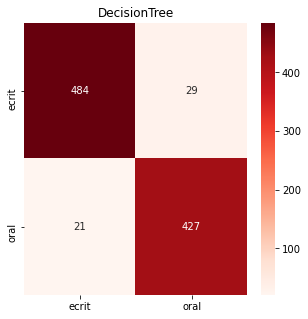

**************
Voici l'ordre de classement des classifieurs [['SVM', 0.97], ['Random Forest', 0.96], ['Perceptron', 0.96], ['DecisionTree', 0.95], ['Nearest Neighbors', 0.55]]


In [12]:
#SEULEMENT SUR DIFFERENTS CLASSIFIEURS, AVEC MEME PRETRAITEMENTS
V = CountVectorizer()
X1 = data["texte"].fillna("x").values.tolist()
y = data["label"]
stopw = set(stopwords.words('french'))
X = V.fit_transform(X1)

#faire varier taille test_size et en tirer graphiques
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
dico_acc_g = {}

for nom, classif in liste_classif:
    classif.fit(X_train, y_train)
    y_pred = classif.predict(X_test)
    dico_acc_g[nom]=round(accuracy_score(y_test,y_pred),2)
    print(nom)
    fig, ax = plt.subplots(figsize=(5,5))
    classes = ["ecrit", "oral"]
    
    matrice_confusion = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrice_confusion, cmap = plt.cm.Reds, 
                xticklabels=classes, yticklabels=classes, 
                annot=True, fmt ="d")

    nom_img = "oralecrit_conf_matrix_%s.png"%nom
    plt.title(nom)
    plt.savefig(nom_img)
    plt.show()
    print("**************")
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

In [13]:
#SUR DIFFERENTS VECTORISEURS, SUR DIFFERENTS CLASSIFIEURS, AVEC MEME PRETRAITEMENTS
dico_acc_g = {}
for nom_v, vectorizer in liste_vec:
#     print(nom_v)
    V = vectorizer
    X = V.fit_transform(X1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
    for nom, classif in liste_classif:
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test)
        dico_acc_g[nom_v+" "+nom]=round(accuracy_score(y_test,y_pred),2)
        print(nom_v, nom)
        #print(confusion_matrix(y_test,y_pred))
        print(classification_report(y_test,y_pred))
        print("*"*100)
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

CountVectorizer Perceptron
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       513
           1       0.96      0.96      0.96       448

    accuracy                           0.96       961
   macro avg       0.96      0.96      0.96       961
weighted avg       0.96      0.96      0.96       961

****************************************************************************************************
CountVectorizer SVM
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       513
           1       0.98      0.96      0.97       448

    accuracy                           0.97       961
   macro avg       0.97      0.97      0.97       961
weighted avg       0.97      0.97      0.97       961

****************************************************************************************************
CountVectorizer Nearest Neighbors
              precision    recall  f1-score   support

        

Perceptron


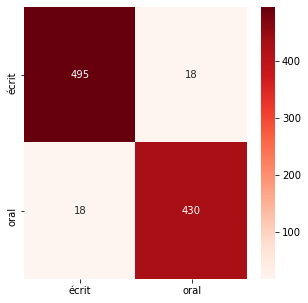

****************************************************************************************************
SVM


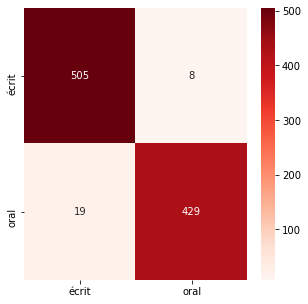

****************************************************************************************************
Nearest Neighbors


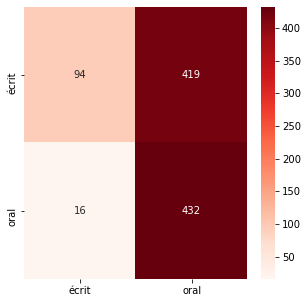

****************************************************************************************************
Random Forest


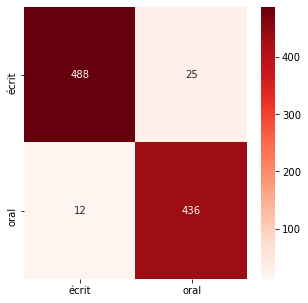

****************************************************************************************************
DecisionTree


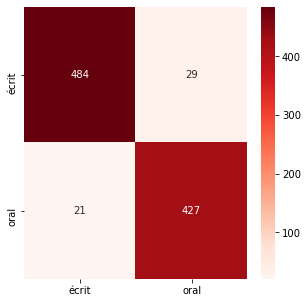

****************************************************************************************************
Voici l'ordre de classement des classifieurs [['SVM', 0.97], ['Random Forest', 0.96], ['Perceptron', 0.96], ['DecisionTree', 0.95], ['Nearest Neighbors', 0.55]]


In [14]:
#SEULEMENT SUR DIFFERENTS CLASSIFIEURS, AVEC MEME PRETRAITEMENTS
V = CountVectorizer()
X = V.fit_transform(X1)

#faire varier taille test_size et en tirer graphiques
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
dico_acc_g = {}

for nom, classif in liste_classif:
    classif.fit(X_train, y_train)
    y_pred = classif.predict(X_test)
    dico_acc_g[nom]=round(accuracy_score(y_test,y_pred),2)
    print(nom)
    fig, ax = plt.subplots(figsize=(5,5))
    classes = ["écrit", "oral"]
    matrice_confusion = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrice_confusion, cmap = plt.cm.Reds, 
                xticklabels=classes, yticklabels=classes, 
                annot=True, fmt ="d")

#     nom_img = "oralecrit_conf_matrix_%s.png"%nom
#     plt.title(nom)
#     plt.savefig(nom_img)
    plt.show()
    print("*"*100)
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

On teste chaque prétraitement sur chaque classifieur

In [15]:
#BOUCLE SUR PRETRAITEMENTS + CLASSIFIEURS 
#tester individuellement chaque pré-traitement combiné à chaque classifieur
import time
start_time = time.time()
dico_acc = {}

for nom_param, vec in liste_param:
    #préciser quel jeu de données sinon va le redemander à chaque itération
    X = V.fit_transform(X1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

    for nom, classif in liste_classif:
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test)
        dico_acc[nom+" / "+nom_param]=round(accuracy_score(y_test,y_pred),2)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 31.65081238746643 seconds ---


In [16]:
#pour extraire seulement les meilleurs et les pires scores (plus lisible)
dico_acc_trie = trier_dic(dico_acc)

print("Les 5 meilleurs : ".upper())
for parametres, score in dico_acc_trie[:5]:
    print(parametres, score)
   
print("\nLes 5 pires : ".upper())
for parametres, score in dico_acc_trie[-5:]:
    print(parametres, score)  

LES 5 MEILLEURS : 
SVM / sans stop_words 0.97
SVM / par caractère 0.97
SVM / avec bigrammes 0.97
SVM / avec 500 mots 0.97
SVM / avec 2000 mots 0.97

LES 5 PIRES : 
Nearest Neighbors / par caractère 0.55
Nearest Neighbors / avec bigrammes 0.55
Nearest Neighbors / avec 500 mots 0.55
Nearest Neighbors / avec 2000 mots 0.55
Nearest Neighbors / avec 1000 mots 0.55


On combine plusieurs pré-traitements sur chaque classifieur

In [17]:
#BOUCLE POUR AVOIR DIFFERENTS CLASSIFIEURS ET POUR CHACUN, COMBINAISON DE N-GRAMMES + 1 AUTRE PRETRAITEMENT (ou 2)
import time
start_time = time.time()
#dico json forme {nom_classif_param : {y_test:vlr, y_pred:vlr}}
# X1,y,stopw = choix_data(1)
stopw = set(stopwords.words('french'))
dico_json = {}
liste_vectorizer = []
liste_vectorizer_1000 = []
liste_vectorizer_stop = []
liste_vectorizer_all = []
liste_v = [["sans pré-traitements",liste_vectorizer],
           ["seulement les 1000 mots les plus fréquents",liste_vectorizer_1000],
           ["sans stopwords",liste_vectorizer_stop],
           ["seulement 1000 mots et sans stopwords", liste_vectorizer_all]]

for analyzer in ["word", "char"]:
    a = analyzer
    for n in range(10):
        nom = a+" "+str(n)
        liste_vectorizer.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n))])
        liste_vectorizer_1000.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n), max_features=1000)])
        liste_vectorizer_stop.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n), stop_words=stopw)])
        liste_vectorizer_all.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n), max_features=1000, stop_words=stopw)])

dico_acc2 = {}
for nom_l, liste in liste_v :
    for nom_param, vec in liste:
        V = vec

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
        for nom_c, classif in liste_classif:
            classif.fit(X_train, y_train)
            y_pred = classif.predict(X_test)
            dico_acc2[nom_c+" / "+nom_l+" / "+nom_param]="%.2f"%accuracy_score(y_test,y_pred)
        dico_json[nom_c+" / "+nom_l+" / "+nom_param]={}
        dico_json[nom_c+" / "+nom_l+" / "+nom_param]["y_test"]=y_test
        dico_json[nom_c+" / "+nom_l+" / "+nom_param]["y_pred"]=y_pred

print("--- %s seconds ---" % (time.time() - start_time))

--- 410.67360520362854 seconds ---


In [18]:
#pour extraire seulement les meilleurs et les pires scores (plus lisible)
dico_acc2_trie = trier_dic(dico_acc2)

#meilleur affichage : 
print("Les 10 meilleurs : ".upper())
for parametres, score in dico_acc2_trie[:10]:
    print(parametres, score)
   
print("\nLes 10 pires : ".upper())
for parametres, score in dico_acc2_trie[-10:]:
    print(parametres, score)  
    
#Comme ça prend du temps d'obtenir tous ces résultats, on sauvegarde tous les accuracy_score obtenus dans un json
# w = open("accuracy_allclassif_tweets_tfidf.json", "w", encoding="utf-8")
# w.write(json.dumps(dico_acc2_trie, indent=2, ensure_ascii=False))
# w.close()

LES 10 MEILLEURS : 
SVM / seulement les 1000 mots les plus fréquents / word 9 0.97
SVM / seulement les 1000 mots les plus fréquents / word 8 0.97
SVM / seulement les 1000 mots les plus fréquents / word 7 0.97
SVM / seulement les 1000 mots les plus fréquents / word 6 0.97
SVM / seulement les 1000 mots les plus fréquents / word 5 0.97
SVM / seulement les 1000 mots les plus fréquents / word 4 0.97
SVM / seulement les 1000 mots les plus fréquents / word 3 0.97
SVM / seulement les 1000 mots les plus fréquents / word 2 0.97
SVM / seulement les 1000 mots les plus fréquents / word 1 0.97
SVM / seulement les 1000 mots les plus fréquents / word 0 0.97

LES 10 PIRES : 
Nearest Neighbors / sans pré-traitements / char 9 0.55
Nearest Neighbors / sans pré-traitements / char 8 0.55
Nearest Neighbors / sans pré-traitements / char 7 0.55
Nearest Neighbors / sans pré-traitements / char 6 0.55
Nearest Neighbors / sans pré-traitements / char 5 0.55
Nearest Neighbors / sans pré-traitements / char 4 0.55
Nea

On regarde les erreurs qui persistent dans le code, même avec les meilleures combinaisons

In [32]:
def not_match(y_test,y_pred,X1):
    ''' Fonction qui renvoie les mauvaises classifications d'un modèle'''
    y_test = y_test.to_dict()
    i=0
    not_match_positifs = []
    not_match_negatifs = []
    for yp_k, yp_v in y_test.items():
        if y_pred[i] != y_test[yp_k]:
            #si la prédiction est 1 et la valeur réelle 0 = croit que positif alors que négatif
            if y_pred[i] > y_test[yp_k]:
                not_match_positifs.append(X1[yp_k])
            else:
                not_match_negatifs.append(X1[yp_k])
        i+=1

    return not_match_positifs,not_match_negatifs
                    
#meilleure combinaison
#V = CountVectorizer(stop_words=stopw)
V = CountVectorizer()
X = V.fit_transform(X1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
phr_not_match_positifs, phr_not_match_negatifs = not_match(y_test,y_pred,X1)

In [43]:
print("Il y a",len(phr_not_match_positifs), "phrases classées orales alors qu'elles sont en réalité écrites. En voici quelques exemples :")
for i in range (5):
    print("\n\t",phr_not_match_positifs[i])
print("-"*80)
print("Il y a",len(phr_not_match_negatifs), "phrases classées écrites alors qu'elles sont en réalité orales. En voici quelques exemples :")
for i in range (5):
    print("\n\t",phr_not_match_negatifs[i])

Il y a 8 phrases classées orales alors qu'elles sont en réalité écrites. En voici quelques exemples :

	 faire, même quand on se dit «oh là là mais c'est pas possible !», comme dans The Wedding Singer ou Punch-Drunk Love, on l'aime. Il fallait que H

	 cela l'a rendu si beau, ça changeait tout. Et là on s'est dit «ah, d'accord, ce genre de truc est possible » C'est ce qu'il a fait pour Uncut Ge

	 même pas les filmer en gros plans !» Mais on s'en fiche ! On ne fait pas ça pour les gros plans, on fait ça pour les comédiens et parce qu'on le 

	 a vous rend très vulnérable de jouer une scène de sexe. Parfois vous êtes déshabillé, parfois pas, mais émotion-nellement vous êtes toujours nu. 

	 st pas Giscard qui est moderne, ce sont les photographes de l'agence Gamma dont je suis alors le directeur. On a des appareils légers, on est bon
--------------------------------------------------------------------------------
Il y a 19 phrases classées écrites alors qu'elles sont en réalité orales. 

# Classification des tweets

In [34]:
#APPLIQUER CLASSIFIEUR AUX TWEETS
def ouvrir_json(chemin):
  f = open(chemin, encoding="utf-8")
  toto = json.load(f)
  f.close()
  return toto

tweets = ouvrir_json("corpus/1700tweets.json")


X_tweets = V.transform(tweets)
pred = clf.predict(X_tweets)

d = {}
for t in pred:
    d.setdefault(t, 0)
    d[t]+=1
print(d)

{0: 1650, 1: 50}


## Tweets classifiés oraux

In [41]:
for i,tweet in enumerate(tweets):
    #print(tweet,pred[i])
    if pred[i]==1:
        print(tweet, pred[i])
        print("*"*80)

@LCI Cette après midi nous sommes allés voir le film sur notre Dame. 
À un moment on voit Dame hidalgo, dans le film. 
Gros malaise dans la salle.... 
On a tous ri.on ne s y attendait pas. 
Par contre bel hommage aux pompiers,  et à ce que représente Notre-Dame.  Donc allez le voir 1
********************************************************************************
@ZacheeLePub @HanamiUkiyoe @Exlibris401 @JLMelenchon Le principe c'est pas de rester bloqué sur le météore, mais de comprendre la phrase comme "restez dans le déni". Le contraire "look up" ce serait "voir la réalité en face", et dans le film c'est -&gt; regarder le météore. 1
********************************************************************************
@kxmece @MatteoSapin Bah c'est les 2 premiers films du Sony's Spider-Man Universe.
Disons que ça commence pas très bien quoi...
Les 3 derniers Spiderman sont du cru MCU qui rentre pas dans l'univers de Sony doooonc...
Morbius est le 3eme film de ce nouvel univers qui commence

## Tweets classifiés écrits

In [36]:
for i,tweet in enumerate(tweets):
    #print(tweet,pred[i])
    if pred[i]==0:
        print(tweet, pred[i])
        print("*"*80)

RT @MarvelStory_: Vous l’attendiez, le film événement ‘AVENGERS: ENDGAME’ arrivera le 8 avril sur Disney+ en France ! https://t.co/pNAsY5rg… 0
********************************************************************************
RT @viewsfrance: Pour Netflix, Kid Cudi va écrire et réaliser son premier film ! Il jouera également dedans.

Intitulé "Teddy", le long-mét… 0
********************************************************************************
RT @sentieriselvagg: 40° Torino Film Festival: le anticipazioni https://t.co/x7VHP0ZMxD 0
********************************************************************************
RT @eviltwin_horror: Je me rend compte que je ne partage pas a chaque fois le #witchingwatchlist challenge de @HorroriteS 
Je corrige ce so… 0
********************************************************************************
RT @carolyonne89: Le film d’Arte qui montre que l’Ukraine est une plaque tournante du trafic international d’enfants https://t.co/SNyaoph94D 0
**************

@MarinaRavidat @LabouryMarine j’ai vu le tweet passer hier et j’ai toujours pas trouvé le film parfait 🥲 0
********************************************************************************
@normand95244005 @Le_Figaro Arrêtez de rêver et comprenez une fois pour toute que les maliens ne veulent plus de vous tournez la page se mentir à sois ne fait pas évoluer le film est terminé 0
********************************************************************************
Je sors de #TheBatman le film est incroyable l’atmosphère est bien sombre, la bande son est parfaite Robert Pattinson quel acteur il répond à toutes les critiques et joue extrêmement bien le rôle et l’alchimie avec Catwoman rien à dire. J’ai hâte de voir la suite https://t.co/cc2VkBAwDh 0
********************************************************************************
RT @JVCom: Alerte Rouge est un immense succès sur Disney+ !

Le film d'animation signe le meilleur démarrage de la plateforme (en nombre d'… 0
************************

********************************************************************************
Vrmt trop fan du concept des factions le film est lourd :,( https://t.co/oHlF1qUvoJ 0
********************************************************************************
Le film retrace l'histoire de @LauraetAlice et de #JulieDouib 🌹🕊

Toutes nos pensées vont à Julie, ses parents, ses enfants.
Ainsi qu'à Laura, qui continu son combat contre les violences faites aux femmes et pour les enfants. 

Il sera diffusé le 29 mars sur nos écrans . https://t.co/MbniVeF1LZ 0
********************************************************************************
@Ramprab42727566 @MrDhaniyala @PKadmirer03 Brother, miru movie disaster ayina frustration lo unnaru ani telisindi le... 

So, mi movie disaster ayite maa movie rotta film, waste film antaru yenti..? 

Rotta/utter flop ayitene 100cr varaku vachindaa bro collections.? 0
********************************************************************************
RT @SeriesUpdateFR: Le 

********************************************************************************
RT @KatBoyFR: PS : Si vous voulez savoir le genre de tweet qu'on m'as reproché c'était par exemple un tweet disant "Ya un mec qui porte un… 0
********************************************************************************
@HorizonUnivers Super série j ai adoré ....le film sur Netflix bcp moins 0
********************************************************************************
RT @Ryo_Saeba_3: Première image de 金手指 Golden Finger de Felix Chong (Project Gutenberg) avec Andy Lau, Tony Leung Chiu-wai, Simon Yam, Char… 0
********************************************************************************
@MarcCassivi Par curiosité morbide ou intérêt? Vraiment je suis heureux d'avoir arrêté après le premier film et fini le tout sur une bonne note. 0
********************************************************************************
@Lamdallas2 Non mais le gars a droit d'expliquer comment il l'a réalisé ! Le prochain fi

RT @SeriesUpdateFR: Il y a 8 ans, le film Divergente sortait au cinéma. https://t.co/zfua1pcA2C 0
********************************************************************************
RT @KonixInteract: À l’occasion de la sortie du film #Morbius le 30 mars, on organise un jeu concours avec @SonyPicturesFr ! Pour participe… 0
********************************************************************************
RT @anne_sinclair: Très émue de voir le nom de mon grand père en titre de cet avant papier élogieux de @RenaudMachart  @lemondefr. Il parle… 0
********************************************************************************
RT @AndreAr94310915: Nos Jeunesses Communistes, avec l'argent des taxes, produisent un film de propagande politique pour attaquer Duhaime e… 0
********************************************************************************
J’ai vu ce film en avant première en janvier Il sort demain Je vous le conseille vivement 🎬 
#lombredunmensonge 
#boulilanners à Cinémas du Palais ht